In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
val_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(10),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=val_transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])


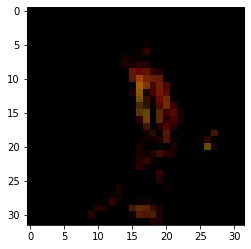

In [7]:
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
print(imgs.size())
data_iter = iter(train_loader)
imgs, labels = data_iter.next()
plt.imshow(imgs[0].permute(1,2,0))

In [9]:
class Minami(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
        #畳み込み層
            #32×32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            #半分
            nn.MaxPool2d(kernel_size=2),#16×16
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #半分
            nn.MaxPool2d(kernel_size=2),#8×8
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #半分
            nn.MaxPool2d(kernel_size=2),#4×4
            
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #半分
            nn.MaxPool2d(kernel_size=2),#2×2
        )

        self.classifier = nn.Sequential(
        #全結合層
            nn.Linear(in_features=2 * 2 * 128, out_features=num_classes),
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size(0), -1) # 畳込層らの出力をLinearに入力するために1次元変換
        output = self.classifier(output) # 上の2行消したらoutputをxに変更
        return output

In [10]:
model = Minami(10)
model.to(device)

Minami(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
num_epochs = 15
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0


    #学習ループ
    model.train()

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        train_acc += (pred == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    

    #検証ループ
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
          
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            pred = torch.argmax(outputs, dim=1)
            val_acc += (pred == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

        
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
           .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/15], Loss: 0.0441, val_loss: 0.0334, val_acc: 0.6267
Epoch [2/15], Loss: 0.0312, val_loss: 0.0286, val_acc: 0.6810
Epoch [3/15], Loss: 0.0264, val_loss: 0.0264, val_acc: 0.7044
Epoch [4/15], Loss: 0.0238, val_loss: 0.0231, val_acc: 0.7486
Epoch [5/15], Loss: 0.0221, val_loss: 0.0228, val_acc: 0.7531
Epoch [6/15], Loss: 0.0208, val_loss: 0.0235, val_acc: 0.7514
Epoch [7/15], Loss: 0.0198, val_loss: 0.0220, val_acc: 0.7647
Epoch [8/15], Loss: 0.0191, val_loss: 0.0211, val_acc: 0.7685
Epoch [9/15], Loss: 0.0182, val_loss: 0.0220, val_acc: 0.7672
Epoch [10/15], Loss: 0.0178, val_loss: 0.0216, val_acc: 0.7664
Epoch [11/15], Loss: 0.0170, val_loss: 0.0224, val_acc: 0.7693
Epoch [12/15], Loss: 0.0167, val_loss: 0.0220, val_acc: 0.7697
Epoch [13/15], Loss: 0.0161, val_loss: 0.0211, val_acc: 0.7791
Epoch [14/15], Loss: 0.0161, val_loss: 0.0206, val_acc: 0.7871
Epoch [15/15], Loss: 0.0155, val_loss: 0.0217, val_acc: 0.7775


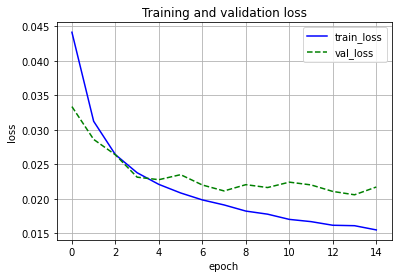

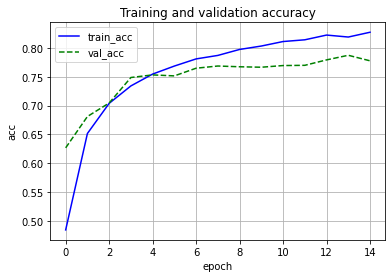

In [13]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()